In [1]:
import os
import shutil
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

current_directory = os.getcwd()
path_components = current_directory.split(os.path.sep)
new_directory = os.path.sep.join(path_components[:-1])
sys.path.append(new_directory)


## Post processing framework

#### Simulation Name

In [2]:
simulation_name = 'Main'
simulation_folder = 'tests'

results_dir = os.path.sep.join(path_components[:-2])
results_path = os.path.join(results_dir,'.results',simulation_folder,simulation_name)
main_path = os.path.join(results_dir,'code')
shutil.copyfile(os.path.join(results_path,simulation_name+'.py'), os.path.join(main_path,'S_temp.py'))
print(main_path)
print(results_path)

/home/martinachondo/PINN/code
/home/martinachondo/PINN/.results/tests/Main


In [7]:
folder_name = 'S_temp'
folder_path = os.path.join(main_path,'results',folder_name)

from S_temp import PDE
from S_temp import network
from S_temp import equation

sim = PDE()
N_points = {'hmin_interior': 0.01,
            'hmin_exterior': 0.5,
            'density_mol': 40,
            'density_border': 4,
            'dx_experimental': 2,
            'N_pq': 100,
            'G_sigma': 0.04,
            'mesh_generator': 'msms',
            'dR_exterior': 6
                }
for key,value in N_points.items():
    sim.N_points[key] = value
print(sim.inputs)
sim.create_simulation()

XPINN_solver = sim.XPINN_solver


{'molecule': 'born_ion', 'epsilon_1': 1, 'epsilon_2': 80, 'kappa': 0.125, 'T': 300}
/home/martinachondo/PINN/code/Mesh/Mesh_softwares/MSMS/msms -if /home/martinachondo/PINN/code/Molecules/born_ion/born_ion.xyzr -of /home/martinachondo/PINN/code/Molecules/Saved_meshes/Temp/born_ion_d40 -p 1.4 -d 40 -no_header
MSMS 2.6.1 started on tulio
Copyright M.F. Sanner (1994)
Compilation flags -O2 -DVERBOSE -DTIMING
Atom 2 ignored, radius = 0.010000
INPUT  /home/martinachondo/PINN/code/Molecules/born_ion/born_ion.xyzr 1 spheres 0 collision only, radii  1.000 to  1.000
PARAM  Probe_radius  1.400 density 40.000 hdensity  3.000
REDUCED SURFACE ...
    1 free vertex (vertices) found
    RS component  #faces  #edges #free_edges  #vertices   genus
         0           0        1          0          1      1
    Time Reduced Surface real: 0.00 user: 0.00 sys: 0.00
ANALYTICAL SOLVENT EXCLUDED SURFACE...
    Component   0
        Time Surface real: 0.00 user: 0.00 sys: 0.00
    SES comp.  #fac.  #edg. #s_e

Region point: Tensor({0}:0.0276667; {1}:-0.796333; {2}:-0.230667)
Delaunizing vertices...
Delaunay seconds:  0.012448
Creating surface mesh ...
Surface mesh seconds:  0.000999
Recovering boundaries...
Boundary recovery seconds:  0.002006
Removing exterior tetrahedra ...
Spreading region attributes.
Exterior tets removal seconds:  0.000229
Recovering Delaunayness...
Delaunay recovery seconds:  0.010799
Refining mesh...
  613 insertions, added 222 points, 11521 tetrahedra in queue.
  204 insertions, added 19 points, 11759 tetrahedra in queue.
  272 insertions, added 16 points, 11874 tetrahedra in queue.
  362 insertions, added 17 points, 11832 tetrahedra in queue.
  483 insertions, added 13 points, 11298 tetrahedra in queue.
  644 insertions, added 4 points, 9910 tetrahedra in queue.
  858 insertions, added 2 points, 5430 tetrahedra in queue.
Refinement seconds:  0.021281
Smoothing vertices...
Mesh smoothing seconds:  0.023221
Improving mesh...
Mesh improvement seconds:  0.000985

Writin

In [9]:
Iter = 2
if network == 'xpinn':
    from NN.NeuralNet import XPINN_NeuralNet as NeuralNet
XPINN_solver.folder_path = folder_path
XPINN_solver.load_NeuralNet(NeuralNet,results_path,f'iter_{Iter}')
XPINN_solver.N_iters = XPINN_solver.iter

In [10]:
from Post.Postcode import Born_Ion_Postprocessing as Postprocessing
Post = Postprocessing(XPINN_solver, save=True, directory=folder_path)

OpenMesh not available
No module named 'openmesh'


In [11]:
df = Post.save_values_file(save=False)
print(json.dumps(df, indent=4))

{
    "Gsolv_value": "0.000",
    "L2_continuity_u": "5.316e-01",
    "L2_continuity_du": "1.594e-01",
    "Loss_XPINN": "2.789e+05",
    "Loss_NN1": "2.664e+05",
    "Loss_NN2": "1.253e+02",
    "L2_analytic": "2.713e+02"
}


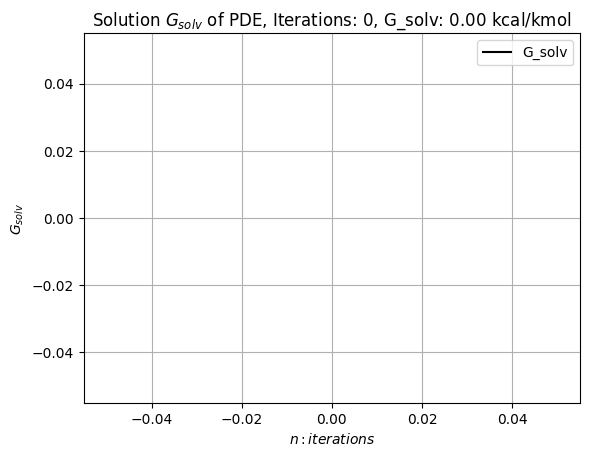

In [12]:
Post.plot_G_solv_history()

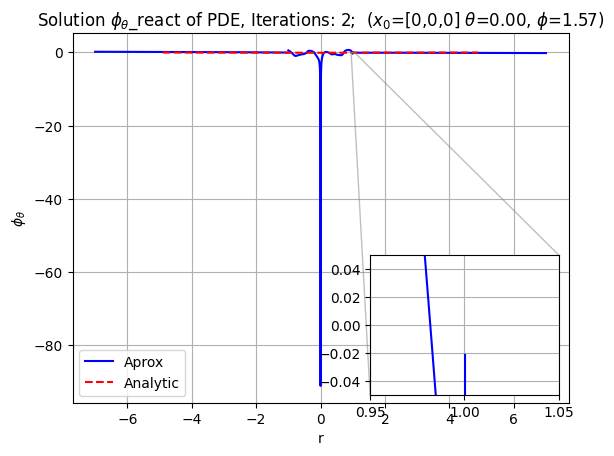

In [14]:
Post.plot_aprox_analytic(N=8000,zoom=True, lims_zoom=[[0.95,1.05],None], value='react')

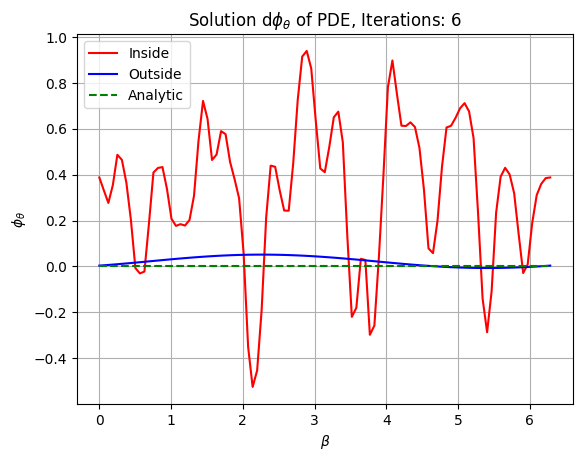

In [22]:
Post.plot_line_interface()

In [23]:
Post.plot_mesh_3D()
Post.plot_interface_3D('phi')
Post.plot_interface_3D('dphi')

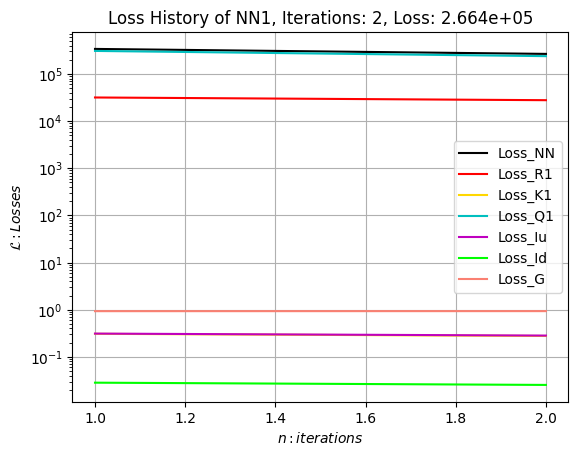

In [15]:
Post.plot_loss_history(domain=1)

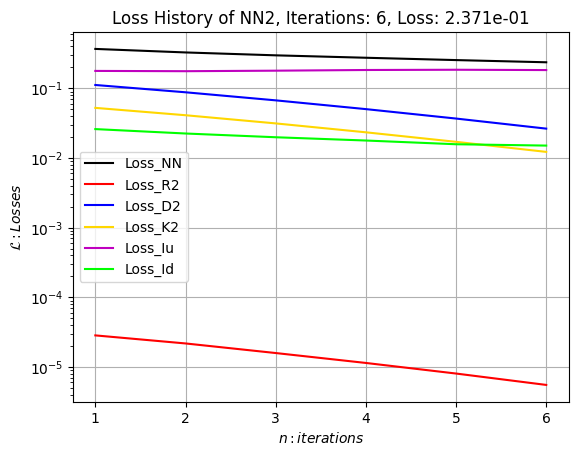

In [25]:
Post.plot_loss_history(domain=2)

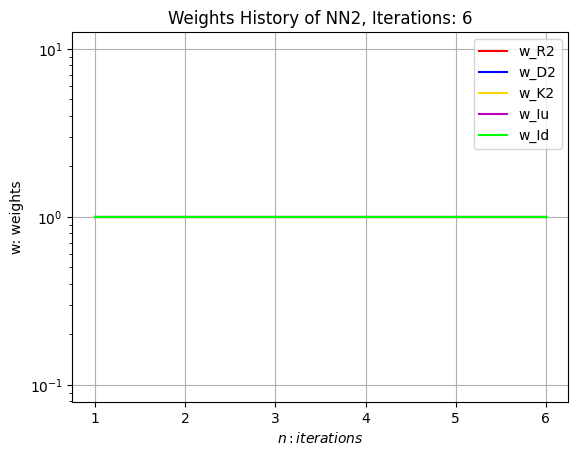

In [26]:
Post.plot_weights_history(domain=2)

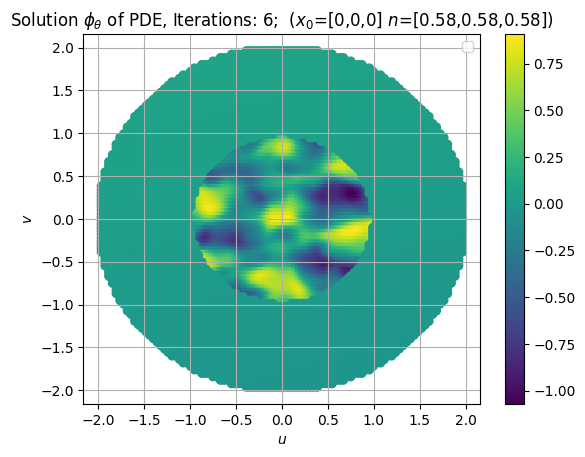

In [27]:
Post.plot_phi_contour(n=np.array([1,1,1]))

In [10]:
Post.plot_vol_mesh_3D(jupyter=True)

ERROR getVolume(): Orientation undefined for one or more simplices. Did you call compute_orientation()?
ERROR getVolume(): Orientation undefined for one or more simplices. Did you call compute_orientation()?


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

#### Aditional computations

In [14]:
import bempp.api

u_interface,_,_ = Post.PDE.get_phi_interface(*Post.NN)
u_interface = u_interface.flatten()
_,du_1,du_2 = Post.PDE.get_dphi_interface(*Post.NN)
du_1 = du_1.flatten()
du_2 = du_2.flatten()
du_1_interface = (du_1+du_2*Post.NN[1].PDE.epsilon/Post.NN[0].PDE.epsilon)/2

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

phi_q = Post.PDE.slp_q * dphi - Post.PDE.dlp_q * phi

slp_aprox = Post.PDE.slp_q * dphi
dlp_aprox = Post.PDE.dlp_q * phi

In [15]:
print('slp',slp_aprox)
print('dlp', dlp_aprox)

slp [[-0.04577357]]
dlp [[-0.00114817]]


In [16]:
Rs = np.linalg.norm(Post.PDE.mesh.mol_verts, axis=1)

u_interface = Post.PDE.analytic_Born_Ion(Rs)
du_1_interface = Post.PDE.analytic_Born_Ion_du(Rs)

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

slp_an = Post.PDE.slp_q * dphi
dlp_an = Post.PDE.dlp_q * phi

In [17]:
print('slp',slp_an)
print('dlp', dlp_an)

slp [[-0.07938546]]
dlp [[-0.00094506]]


In [18]:
def get_Gsolv(slp,dlp):
  phi_q = slp - dlp
  G_solv = 0.5*np.sum(Post.PDE.qs * phi_q).real
  G_solv *= Post.PDE.to_V*Post.PDE.qe*Post.PDE.Na*(10**-3/4.184) 
  return G_solv

In [19]:
print('aprox',get_Gsolv(slp_aprox,dlp_aprox))
print('an',get_Gsolv(slp_an,dlp_an))

aprox -93.10722575405698
an -163.65945134158008


In [20]:
print('ap-an',get_Gsolv(slp_aprox,dlp_an))
print('an-ap',get_Gsolv(slp_an,dlp_aprox))

ap-an -93.53099959788352
an-ap -163.23567749775356
